In [2]:
!nvidia-smi

Sun Mar  1 01:37:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 观察jena天气数据集

In [0]:
import os

In [0]:
data_dir = './drive/My Drive/Data/jena'

In [0]:
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [17]:
f = open(fname)
data = f.read()
f.close

<function TextIOWrapper.close>

In [0]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]  # 排除表头

In [19]:
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


# 解析数据

In [0]:
import numpy as np

In [0]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

# 准备数据

## 数据标准化

In [0]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

## 生成时间序列的样本及其目标的生成器

In [0]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

## 准备训练生成器、验证生成器和测试生成器

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [0]:
train_gen = generator(data=float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(data=float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(data=float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

# 使用循环dropout来降低过拟合

## 循环层堆叠

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [0]:
model = Sequential()
model.add(layers.GRU(units=32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(units=64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 32)          4512      
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 23,201
Trainable params: 23,201
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer=RMSprop(), loss='mae')  # RMSprop()一定要加括号

In [0]:
history = model.fit_generator(generator=train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 373s 747ms/step - loss: 0.3125 - val_loss: 0.2724
Epoch 2/40
500/500 [==============================] - 374s 747ms/step - loss: 0.3071 - val_loss: 0.2742
Epoch 3/40
500/500 [==============================] - 374s 748ms/step - loss: 0.3029 - val_loss: 0.2707
Epoch 4/40
500/500 [==============================] - 373s 745ms/step - loss: 0.2995 - val_loss: 0.2737
Epoch 5/40
500/500 [==============================] - 374s 747ms/step - loss: 0.2957 - val_loss: 0.2742
Epoch 6/40
500/500 [==============================] - 374s 747ms/step - loss: 0.2927 - val_loss: 0.2680
Epoch 7/40
500/500 [==============================] - 373s 745ms/step - loss: 0.2911 - val_loss: 0.2674
Epoch 8/40
500/500 [==============================] - 373s 746ms/step - loss: 0.2870 - val_loss: 0.2675
Epoch 9/40
500/500 [==============================] - 373s 746ms/step - loss: 0.2858 - val_loss: 0.2661
Epoch 10/40
500/500 [==============================] - 371s 741m

In [0]:
model.save('stack_gru.h5')

## 绘制结果

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [0]:
epochs = range(1, len(loss) + 1)

In [0]:
from matplotlib import pyplot as plt

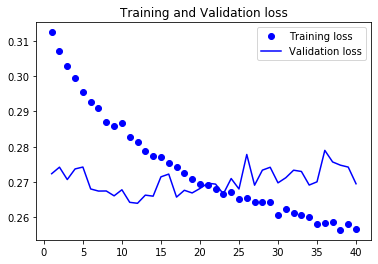

In [0]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

# 使用双向RNN

## 使用逆序序列训练并评估一个LSTM

In [3]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

Using TensorFlow backend.


In [0]:
max_features = 10000
maxlen = 500

In [5]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

17465344/17464789 [==============================] - 1s 0us/step


In [0]:
# 序列翻转

In [0]:
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

In [0]:
# 填充序列

In [0]:
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

In [0]:
model = Sequential()
model.add(layers.Embedding(input_dim=max_features, output_dim=128))
model.add(layers.LSTM(units=32))
model.add(layers.Dense(units=1, activation='sigmoid'))

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,300,641
Trainable params: 1,300,641
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])  # RMSprop()一定要加括号

In [0]:
history = model.fit(x_train, y_train, epochs=10, batch_size = 128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 106s 5ms/step - loss: 0.5043 - acc: 0.7529 - val_loss: 0.3511 - val_acc: 0.8616
Epoch 2/10
20000/20000 [==============================] - 104s 5ms/step - loss: 0.3180 - acc: 0.8778 - val_loss: 0.3387 - val_acc: 0.8610
Epoch 3/10
20000/20000 [==============================] - 103s 5ms/step - loss: 0.2581 - acc: 0.9072 - val_loss: 0.7297 - val_acc: 0.7576
Epoch 4/10
20000/20000 [==============================] - 105s 5ms/step - loss: 0.2222 - acc: 0.9191 - val_loss: 0.3597 - val_acc: 0.8588
Epoch 5/10
20000/20000 [==============================] - 106s 5ms/step - loss: 0.1916 - acc: 0.9330 - val_loss: 0.3420 - val_acc: 0.8832
Epoch 6/10
20000/20000 [==============================] - 107s 5ms/step - loss: 0.1732 - acc: 0.9393 - val_loss: 0.3795 - val_acc: 0.8654
Epoch 7/10
20000/20000 [==============================] - 108s 5ms/step - loss: 0.1685 - acc: 0.9435 - val_loss: 0.3720 - v

### 绘制结果

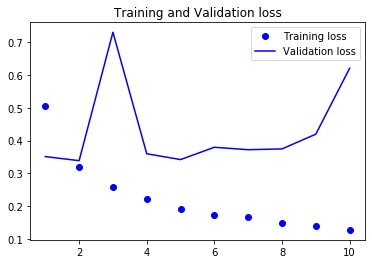

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [0]:
import numpy as np

In [0]:
np.mean(loss)

0.22520977923393248

## 训练并评估一个双向LSTM

In [47]:
model = Sequential()
model.add(layers.Embedding(input_dim=max_features, output_dim=32))
model.add(layers.Bidirectional(layers.LSTM(units=32)))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 336,705
Trainable params: 336,705
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [49]:
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 221s 11ms/step - loss: 0.5534 - acc: 0.7228 - val_loss: 0.4550 - val_acc: 0.7926
Epoch 2/5
20000/20000 [==============================] - 224s 11ms/step - loss: 0.3410 - acc: 0.8638 - val_loss: 0.3339 - val_acc: 0.8634
Epoch 3/5
20000/20000 [==============================] - 225s 11ms/step - loss: 0.2723 - acc: 0.8976 - val_loss: 0.3596 - val_acc: 0.8442
Epoch 4/5
20000/20000 [==============================] - 221s 11ms/step - loss: 0.2261 - acc: 0.9161 - val_loss: 0.3603 - val_acc: 0.8636
Epoch 5/5
20000/20000 [==============================] - 222s 11ms/step - loss: 0.1956 - acc: 0.9287 - val_loss: 0.3717 - val_acc: 0.8606


### 绘制结果

In [0]:
import matplotlib.pyplot as plt

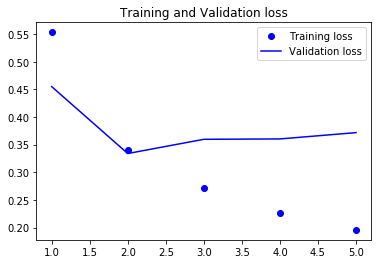

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

## 训练双向GRU

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [55]:
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(units=2), input_shape=(None, float_data.shape[-1])))  # input_shape是Bidirectional的参数
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 4)                 204       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 5         
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer=RMSprop(), loss='mae')

In [58]:
history = model.fit_generator(generator=train_gen, steps_per_epoch=500, epochs=10, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/10
500/500 [==============================] - 327s 655ms/step - loss: 0.3197 - val_loss: 0.2912
Epoch 2/10
500/500 [==============================] - 321s 641ms/step - loss: 0.3001 - val_loss: 0.2799
Epoch 3/10
500/500 [==============================] - 322s 644ms/step - loss: 0.2906 - val_loss: 0.2751
Epoch 4/10
500/500 [==============================] - 325s 649ms/step - loss: 0.2876 - val_loss: 0.2724
Epoch 5/10
500/500 [==============================] - 326s 651ms/step - loss: 0.2849 - val_loss: 0.2704
Epoch 6/10
500/500 [==============================] - 327s 655ms/step - loss: 0.2846 - val_loss: 0.2692
Epoch 7/10
500/500 [==============================] - 326s 651ms/step - loss: 0.2833 - val_loss: 0.2695
Epoch 8/10
500/500 [==============================] - 323s 646ms/step - loss: 0.2821 - val_loss: 0.2686
Epoch 9/10
500/500 [==============================] - 323s 646ms/step - loss: 0.2815 - val_loss: 0.2677
Epoch 10/10
500/500 [==============================] - 322s 645m

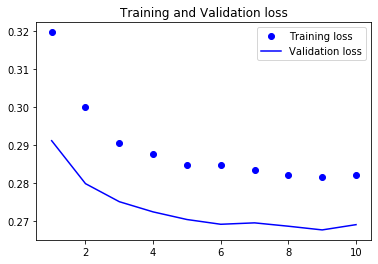

In [59]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [0]:
import numpy as np

In [62]:
np.mean(val_loss)

0.2732973991058795